In [35]:
import os
import operator
from typing import TypedDict, Annotated, List, Union, Optional
from getpass import getpass
from datetime import datetime
from dotenv import load_dotenv

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import BaseMessage, ToolMessage, AIMessage, HumanMessage
from langchain_core.tools import tool
from langchain_google_genai import ChatGoogleGenerativeAI
#from langchain_core.pydantic_v1 import BaseModel, Field

from langgraph.graph import StateGraph, START, END
from langchain.agents import create_tool_calling_agent
from langgraph.prebuilt import ToolNode
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from typing import TypedDict, List
from langchain_core.messages import HumanMessage,SystemMessage
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END

In [5]:
from dateutil.parser import parse

In [6]:
from modules.ytinteraction import ytinteraction

In [7]:
load_dotenv()
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")

In [14]:
@tool
def youtube_search(query: str, order: str = 'viewCount', duration='medium', num_results: int = 1, before: str = None, after: str = None):
    """
    Searches YouTube for videos related to query, inside a timespan.
    Returns a dictionary containing the videos' ids as keys and {title, channel, and date} as values.

    Parameters:
    -----------
        query : str
            Search term.
        order : str
            Search results sorted by one of the following: 'date', 'rating', 'relevance', 'viewCount'.
        duration : str
            Duration of search results: 'any', 'long' (minutes 20+), 'medium' (4-20), 'short' (<4).
        num_results : int
            Number of videos to retrieve.
        before : str
            Date upper limit in form %m/%d/%Y.
        after : str
            Date lower limit in form %m/%d/%Y.
    """
    new = ytinteraction()

    return new.ytretriever(query=query, order=order, duration=duration, num_results=num_results, before=before, after=after)

In [8]:
@tool
def convert_date(date_string: str) -> str:
    """
    Converts a natural language date string into a formal format, like MM/DD/YYYY.
    This is useful for providing a standardized date to the ytretriever tool.

    Parameters:
    -----------
        date_string : str
            A date string in natural language (e.g., "last week", "yesterday", "next Tuesday").

    Returns:
    --------
        str:
            The parsed date in the format %m/%d/%Y.
    """
    try:
        # Use dateutil.parser to handle natural language dates
        parsed_date = parse(date_string)
        # Return the date in the required format
        return parsed_date.strftime('%m/%d/%Y')
    except Exception as e:
        return f"Error: Could not parse date string '{date_string}'. Reason: {e}"

In [ ]:
@tool
def youtube_transcript():
    

In [15]:
tools = [youtube_search, convert_date]

In [10]:
class AgentState(TypedDict):
    """The state of the agent, containing the conversation history."""
    messages: Annotated[List[BaseMessage], operator.add]
    # 'operator.add' here tells LangGraph to append new messages to the list

In [24]:
llm = ChatGoogleGenerativeAI(model="gemini-2.5-pro", temperature=0)
model = llm.bind_tools(tools)


In [ ]:

def our_agent(state: AgentState) -> AgentState:
    system_prompt = SystemMessage(content=f"""
    You are a personal AI assistant. You are going to help the user search for videos on youtube.
                                  
    - If the user wants to do a youtube search, you need to use the ytretriever tool.
    - To give ytretriever dates as input in the right format, you need to use the convert_date tool
""")


    user_input = input("\nDo you want to do a youtube search or are you done? What is your new query? ")
    print(f"\nUSER: {user_input}")
    user_message = HumanMessage(content=user_input)

    all_messages = [system_prompt] + list(state["messages"]) + [user_message]

    response = model.invoke(all_messages)
    print(f"\nAI: {response.content}")
    if hasattr(response, "tool_calls") and response.tool_calls:
        print(f"USING TOOLS: {[tc['name'] for tc in response.tool_calls]}")

    return {"messages": list(state["messages"]) + [user_message, response]}


In [27]:
def should_continue(state: AgentState) -> str:
    """Determine if we should continue or end the conversation"""

    messages = state["messages"]

    if not messages:
        return "continue"
    
    for message in reversed(messages):
        if ("done" in message.content.lower()):
            return "end" # goes to the edge which leads to the endpoint
    return "continue"


def print_messages(messages):
    """Print messages in a more readable form"""

    if not messages:
        return
    
    for message in messages[-3:]:
        if isinstance(message, ToolMessage):
            print(f"\n TOOL RESULT: {message.content}")

In [28]:
graph = StateGraph(AgentState)

graph.add_node("agent", our_agent)
graph.add_node("tools", ToolNode(tools))

graph.set_entry_point("agent")
graph.add_edge("agent", "tools")

graph.add_conditional_edges(
    "tools",
    should_continue,
    {
        "continue": "agent",
        "end": END
    }
)

app = graph.compile()

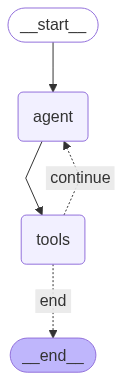

In [29]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [33]:
def youtube_agent():
    print("\n ==== YOUTUBE ASSISTANT ====")

    state = {"messages": []}

    for step in app.stream(state, stream_mode="values"):
        if "messages" in step:
            print_messages(step["messages"])

    print("\n ==== YOUTUBE ASSISTANT FINISHED ====")

In [ ]:
youtube_agent()


 ==== YOUTUBE ASSISTANT ====

AI: I want to find the 5 most popular funny cat videos of this month.
